# Librairies

In [7]:
import glob
from pathlib import Path
import os
import sys
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image, ImageMath

import math

import warnings
import logging

import keras
from keras.layers import Input, Dense, Conv1D, Conv2D, concatenate, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, SGD
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.regularizers import l1 
    
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler

from numpy.random import seed
seed(1)




In [8]:
rootDir = "'/home/charles/Projects/NeuralNetPopulation"
sys.path.append( Path(rootDir) / "Python" )

# Parameters

In [2]:
#Grid size + response variable 
gridSize=100
provider="Mapbox"
verbose = False
resp="v_CA16_406" #v_CA16_2540:poverty -- v_CA16_406:pop_density per sq km
finalNonLin = "sigmoid" if resp == "v_CA16_2540" else "relu" #final non-linearity: sigmoid to predict [0,1] normalized value vs relu otherwise (since response is non-negative)
idGrid="gridId"
ubNumTotal = 3*10**3 #use this upper bound, otherwise it is impossible to load all images into anarray => should most likey think of some better data pipeline where we load batches of images eachtimeS

In [3]:
#Path to output figure/results produced by the algo
figuresOutputPath = Path("." ) / ".." / "Figures" / provider / str(gridSize )

if not os.path.exists(figuresOutputPath):
    print(f"Creating directory {figuresOutputPath}")
    os.makedirs(figuresOutputPath)
else:
    print(f"Directory {figuresOutputPath} already exists")

Directory ../Figures/Mapbox/100 already exists


In [4]:
#Path to output tmp models
modelsOutputPath = Path("." ) / ".." / "Data" / "Models" / provider / str(gridSize )

if not os.path.exists(modelsOutputPath):
    print(f"Creating directory {modelsOutputPath}")
    os.makedirs(modelsOutputPath)
else:
    print(f"Directory {modelsOutputPath} already exists")

Directory ../Data/Models/Mapbox/100 already exists


In [5]:
#Path to save the history as a csv
historyOutputPath = Path("." ) / ".." / "Data" / "History" / provider / str(gridSize )

if not os.path.exists(historyOutputPath):
    print(f"Creating directory {historyOutputPath}")
    os.makedirs(historyOutputPath)
else:
    print(f"Directory {historyOutputPath} already exists")

Directory ../Data/History/Mapbox/100 already exists


In [6]:
#Path to census shp file
shpFilePath = Path(".") / ".." /  "Data" / "GeoData" / "Shp" / "shpCensusMtl.shp"

In [ ]:
#Patht to csv loger
csvLogger = keras.callbacks.CSVLogger(lossCsvFile)

In [7]:
#Parameters for conv net
lr = 5*10**-4
numEpochs=20 # 
batchSize=2**5 #32

l1Coeff = 0 #10**-3
dropoutRate=0.1 #0.6

ConvNetClass = VGG19
convNetName = "Vgg19"

verbose=True

In [8]:
# model name
mdlId = f"{provider}_{resp}_{convNetName}_gridSize_{gridSize}_lr_{lr}_batchSize_{batchSize}_numEpochs_{numEpochs}_l1Coeff_{l1Coeff}_dropoutRate_{dropoutRate}"
mdlId

'Mapbox_v_CA16_406_Vgg19_gridSize_100_lr_0.0005_batchSize_32_numEpochs_20_l1Coeff_0_dropoutRate_0.1'

In [9]:
#Logger 
logBasePath=Path("." ) / ".." / "Log"
logger = logging.getLogger('convNetPred')
hdlr = logging.FileHandler(logBasePath / f"log_{date.today()}_{mdlId}.txt")
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

logger.addHandler(hdlr)
logger.warning(f"{date.today()}")

# Data input

In [33]:
pathPng=Path(".") / ".." / "Output" / str(provider) / str(gridSize) / "Images"
pathCsv = Path(".") / ".." / "Output" / str(provider) / str(gridSize) / "Csv"
listPngs= np.unique([ f for f in pathPng.glob("*.png")] ) # watch out for possible duplicates
mdlId=f"{mdlId}_numImgs_{len(listPngs)}"
print(len(listPngs))

2625


(480, 480, 3)

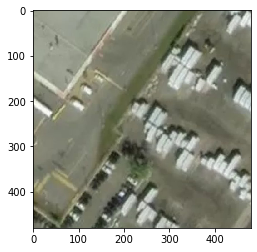

In [34]:
#Quick test
im=Image.open(listPngs[1]).convert('RGB')
plt.imshow(im)
np.array(im).shape

In [35]:
dfGrid=pd.read_csv(pathCsv / "dfGrid.csv")
dfGrid.drop_duplicates(idGrid, inplace=True) #remove duplicate images
print(dfGrid.shape)
dfGrid.head()

(2085, 11)


Group.1   v_CA16_2213  v_CA16_2540    v_CA16_406      gridId    GeoUID  \
0        1  22503.158417    28.333734  12839.862050   1ahuntsic  24660517   
1        2  23329.019053    18.844351   9601.852952   2ahuntsic  24660513   
2       11           NaN          NaN      0.000000  11ahuntsic  24663351   
3       12           NaN          NaN    201.064136  12ahuntsic  24663351   
4       13           NaN          NaN    722.660359  13ahuntsic  24663351   

                 Q_socio                   neighTouching  numberNeigh  \
0  Bordeaux-Cartierville           Bordeaux-Cartierville          1.0   
1  Bordeaux-Cartierville           Bordeaux-Cartierville          1.0   
2  Bordeaux-Cartierville           Bordeaux-Cartierville          1.0   
3  Bordeaux-Cartierville  Ahuntsic,Bordeaux-Cartierville          2.0   
4  Bordeaux-Cartierville  Ahuntsic,Bordeaux-Cartierville          2.0   

   numberDA    rastID  
0       4.0  ahuntsic  
1       5.0  ahuntsic  
2       1.0  ahuntsic  
3       2.0  ahuntsic  
4       2.0  ahuntsic

In [38]:
#Read in the census vars + geometry
shpCensus = gpd.read_file(shpFilePath)
#fuck you pandas, merging shouldnt have to be such a pain wtf you piece of shit
shpCensus['GeoUID'] =  shpCensus['GeoUID'].astype(str).astype('int64')
shpCensus.head()

Shape_Area Type  Dwellings  Households    GeoUID  Population CD_UID  \
0     0.32098   DA        271         262  24660001         657   2466   
1     0.10672   DA        195         189  24660002         534   2466   
2     0.05993   DA        122         122  24660003         303   2466   
3     0.08228   DA        119         116  24660004         283   2466   
4     0.06276   DA         90          90  24660005         235   2466   

   CSD_UID      CT_UID CMA_UID  \
0  2466023  4620580.03   24462   
1  2466023  4620580.03   24462   
2  2466023  4620580.03   24462   
3  2466023  4620580.03   24462   
4  2466023  4620580.03   24462   

                                            geometry  
0  POLYGON ((-387500.7835405682 203119.8092380889...  
1  POLYGON ((-388010.5792480495 202579.3639201983...  
2  POLYGON ((-387936.5598988483 202646.7247733409...  
3  POLYGON ((-388272.4769774442 202325.03570621, ...  
4  POLYGON ((-388089.0671788535 202002.3662097128...

# Train test holdout split

In [39]:
numTotal = min(ubNumTotal, len(listPngs))
numTrain= math.floor(numTotal*0.8) 
numTest= numTotal - numTrain
numTotal, numTrain, numTest

(2625, 2100, 525)

In [41]:
idxTrain, listImTrain= getIdx( slice(0,numTrain) , idGrid, resp)
idxTest, listImTest= getIdx( slice(numTrain,numTotal), idGrid, resp)

#Get the dimension (fixed) for all images
repDim=listImTrain.shape[1:]

#Quite a bit of errors - missing reponse of error with png images
listImTrain.shape,  listImTest.shape, repDim, idxTrain[:4], idxTest[:4]

((1668, 480, 480, 3), (417, 480, 480, 3), (480, 480, 3), array([[141],
        [350],
        [485],
        [642]]), array([[1629],
        [1786],
        [1968],
        [ 105]]))

In [42]:
#Quick validation: test and train sets must be disjoint
idxTrain[-4:], idxTest[:4]
assert( ~np.any(np.isin( idxTrain , idxTest)))
assert( ~np.any(np.isin( idxTest  , idxTrain)))

In [43]:
#yTrain, yTest = dfGrid.loc[ np.isin( dfGrid[[idGrid]], idxTrain ) , resp], dfGrid.loc[ np.isin( dfGrid[[idGrid]], idxTest ) , resp]
idxTrain, idxTest = idxTrain.ravel(), idxTest .ravel()
yTrain, yTest = dfGrid[[resp]].iloc[idxTrain, ], dfGrid[[resp]].iloc[idxTest, ]

if resp == "v_CA16_2540":
    yTrain = yTrain/100 #convert to percentage and use sigmoid transformation
    yTest = yTest/100 #convert to percentage and use sigmoid transformation
else:
    #normalize
    meanAll=    pd.concat( [yTrain] ).mean().values #don't use the test dataset at all, not even for normalizing values
    stdDevAll=  pd.concat( [yTrain] ).std().values
    yTrain=(yTrain-meanAll)/stdDevAll
    yTest=(yTest-meanAll)/stdDevAll
    
yTrain.head(), yTest.head()

(     v_CA16_406
 141   -0.863227
 350   -0.482020
 485    0.173846
 642    1.494208
 814   -0.112048,       v_CA16_406
 1629   -0.063871
 1786   -0.664462
 1968   -0.687155
 105     0.264970
 314    -1.197987)

In [44]:
[ l.apply( [min,max]) for l in [yTest, yTrain] ]

[     v_CA16_406
 min   -1.433860
 max    5.057438,      v_CA16_406
 min   -1.448403
 max    5.231097]

# Conv net prediction

## Build the model

In [45]:

with warnings.catch_warnings () :
    convNetExtractor = ConvNetClass(include_top=False, 
                               weights='imagenet',
                               classes=1,
                               input_shape= repDim )
if verbose:
    convNetExtractor.summary()
    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 480, 480, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 120, 128)     0         
__________

In [46]:
#Fix the base model layers and use for feature extractiom
#Also get the last layer name

numLayers=len(convNetExtractor.layers)

for k, layer in enumerate(convNetExtractor.layers):
    layer.trainable = False
    
    if k == numLayers-1:
        nameLast = layer.name
        
nameLast

'block5_pool'

In [47]:
inputTensor = convNetExtractor.layers[0].input
outputTensor = convNetExtractor.get_layer(nameLast).output 
mdlSmaller = Model(inputTensor, outputTensor)

#Resnet output
outputMdlSmaller=mdlSmaller(inputTensor)

In [48]:
#Flatten them + use these for prediction
flatLyr = Flatten(name='flatten')(outputMdlSmaller)

#Just one fully connected layers 
finalDenseLyr = Dense(2**4, activation='relu', name='fc2' , activity_regularizer=l1(l1Coeff))(flatLyr) #some evidence of overfiting an poor generalsation power - try with L1 norm

print(f"Dropout rate: {dropoutRate}")
dropoutLyr = Dropout(rate=dropoutRate)(finalDenseLyr) #aggressive dropout to avoid overfitting

finalOutput = Dense(1, activation=finalNonLin, name='predictions')(dropoutLyr) #only 1 class: use sigmoid if resp is bounded within [0,1], else relu

Dropout rate: 0.1


In [ ]:
convNetMdlCustom = Model(inputTensor, finalOutput )
convNetMdlCustom.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 480, 480, 3)       0         
_________________________________________________________________
model_4 (Model)              (None, 15, 15, 512)       20024384  
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
fc2 (Dense)                  (None, 16)                1843216   
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 17        
Total params: 21,867,617
Trainable params: 1,843,233
Non-trainable params: 20,024,384
________________________________________________________

In [ ]:
#Set up the optimization
optInst=adam(lr=lr) 
convNetMdlCustom.compile(loss="mean_squared_error", optimizer=optInst )

In [ ]:
#Early stopping for the evaluation loss
es1 = EarlyStopping(monitor='val_loss',
                    verbose=1,
                    min_delta=10**-3,
                    patience=100)

## Fit the model and eval

In [ ]:
mdlFile = modelsOutputPath / f"weights{mdlId}.h5"
mdlWeights = modelsOutputPath / f"weights{mdlId}.h5"

if os.path.isfile(mdlFile) == False:

    mdlHist = convNetMdlCustom.fit(x=listImTrain,
                                       y=yTrain.values.reshape(-1, 1),
                                       epochs=numEpochs,
                                       batch_size=batchSize,
                                       shuffle=False,
                                       validation_split=0.15,
                                       callbacks=[es1],
                                       verbose=1)

    #convert the dictionary to a dataframe to standardize behaviour
    mdlHist= pd.DataFrame(mdlHist.history)

    # Save the model - save both weights AND model
    convNetMdlCustom.save(str(mdlFile))
    convNetMdlCustom.save_weights(str( mdlWeights))
    
else:
    
    convNetMdlCustom = keras.models.load_model(str(mdlFile)) 



Train on 1417 samples, validate on 251 samples
Epoch 1/20
1417/1417 [==============================] - 1355s 956ms/step - loss: 1.1311 - val_loss: 1.1039
Epoch 2/20
1417/1417 [==============================] - 1213s 856ms/step - loss: 0.9809 - val_loss: 1.1039
Epoch 3/20
1417/1417 [==============================] - 1381s 975ms/step - loss: 0.9809 - val_loss: 1.1039
Epoch 4/20
1417/1417 [==============================] - 1137s 802ms/step - loss: 0.9809 - val_loss: 1.1039
Epoch 5/20
1417/1417 [==============================] - 1135s 801ms/step - loss: 0.9809 - val_loss: 1.1039
Epoch 6/20
1417/1417 [==============================] - 1134s 800ms/step - loss: 0.9809 - val_loss: 1.1039
Epoch 7/20
1417/1417 [==============================] - 1134s 801ms/step - loss: 0.9809 - val_loss: 1.1039
Epoch 8/20
1417/1417 [==============================] - 1231s 869ms/step - loss: 0.9809 - val_loss: 1.1039
Epoch 9/20
 320/1417 [=====>........................] - ETA: 17:06 - loss: 1.0611

In [ ]:
mdlFile = modelsOutputPath / f"model_{mdlId}.h5"
mdlWeights = modelsOutputPath / f"weights_{mdlId}.h5"
historyPath = historyOutputPath / f"history_{mdlId}.csv"

allFileExits = [os.path.isfile(f) for f in [mdlFile,mdlWeights,historyPath ] ]

if np.all(allFileExits) :
    
    convNetMdlCustom = keras.models.load_model(str(mdlFile)) 
    mdlHist = pd.read_csv(str(historyPath))

    
else:
    
    mdlHist = convNetMdlCustom.fit(x=listImTrain,
                                       y=yTrain.values.reshape(-1, 1),
                                       epochs=numEpochs,
                                       batch_size=batchSize,
                                       shuffle=False,
                                       validation_split=0.15,
                                       callbacks=[es1],
                                       verbose=1)

    #convert the dictionary to a dataframe to standardize behaviour
    mdlHist= pd.DataFrame(mdlHist.history)
    mdlHist.to_csv(str(historyPath))
    
    
    # Save the model - save both weights AND model
    convNetMdlCustom.save(str(mdlFile))
    convNetMdlCustom.save_weights(str( mdlWeights))

## Plot and inspect

In [ ]:
#Inspect the new weights distribution
dense1Linear=convNetMdlCustom.get_layer("fc2").get_weights()[0]
dense2Linear=convNetMdlCustom.get_layer("predictions").get_weights()[0]

dense1Offset=convNetMdlCustom.get_layer("fc2").get_weights()[1]
dense2Offset=convNetMdlCustom.get_layer("predictions").get_weights()[1]

listWeights= [dense1Linear,dense1Offset,
              dense2Linear,dense2Offset]

title=["Penultimate - linear","Penultimate - offset", 
       "Last - linear", "Last - offset"]

f = plt.figure(figsize=(10,7))
f.suptitle("Distribution of weghts for 2 last fully connected layers\n\n")

for k,w in enumerate(listWeights):
    plt.subplot(2,2,(k+1))
    sns.distplot(w.ravel(), kde=False)
    numParams = len(w.ravel())
    plt.title(f"{title[k]}\nNumber of parameters: {numParams}")
    
f.tight_layout(  rect  =(0,0,1,0.9))


plt.savefig(figuresOutputPath / f"distributionLastWeights_{mdlId}.png")

In [ ]:
#PLot the objective function evolution
plt.figure(figsize=(10,5))

plt.plot( mdlHist.index, mdlHist['loss'] ,label='Train MSE')
plt.plot( mdlHist.index, mdlHist['val_loss'] ,label='Eval MSE')

plt.title(f"{convNetName} model - accuracy\n{numEpochs} epochs", fontsize=20)

plt.legend(fontsize=16 )

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax=plt.gca()
plt.xlabel(ax.get_xlabel(), fontsize=16)
plt.ylabel(ax.get_ylabel(), fontsize=16)

plt.savefig(figuresOutputPath / f"objectiveFct_{mdlId}.png")

In [ ]:
#Get the test dataset
dfGridTest = dfGrid.loc[ yTest.index   ]
print(dfGridTest.shape)
dfGridTest.head() 

In [ ]:
#Predict values and cmpute residuals
df = dfGridTest
df['pred'] = convNetMdlCustom.predict(listImTest) 
df["obs"] = yTest.values
df['predError'] = [ y-p for y,p in zip(df["obs"],df["pred"]) ]
np.sum(df['predError']**2)**0.5

In [ ]:
#Get the average resp and compare with predictions
avgObs = np.mean(df['obs'])
var = np.sum((df['obs']-avgObs)**2)**0.5 #this also gives an indication of the mse of predicting 0
avgObs ,var

In [ ]:
#Sort by prediction error for plotting
df.sort_values(by=["predError", "obs"], inplace=True)
df.reset_index(inplace=True)
df.head()

In [ ]:
numNeigh=len(df.Q_socio.unique())

In [ ]:
import matplotlib
plt.figure(figsize=(20,15))

plt.title(f"{convNetName} model\nPrediction errors\n{numEpochs} epochs", fontsize=20)

g=sns.scatterplot(x=df.index, y="predError", hue="Q_socio" , data=df)

g.axhline(0)
 
g.legend(title = "Neighbourhood", 
         loc='lower left', 
         bbox_to_anchor=(0.05,-0.5), 
         ncol= int(math.sqrt(numNeigh)),
         fontsize=14)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig(figuresOutputPath / f"sortedPredctions_{mdlId}.png")

In [ ]:
plt.figure(figsize=(20,15))

plt.title(f"{convNetName} model\nObservations vs. predictions\nAverage {resp} : {avgObs:.3}", fontsize=20)

g=sns.scatterplot(x="obs", y="pred", hue="Q_socio" ,data=df)

g.axhline(avgObs) 
    
g.legend(title = "Neighbourhood", 
         loc='lower left', 
         bbox_to_anchor=(0.05,-0.5), 
         ncol= int(math.sqrt(numNeigh)),
         fontsize=14)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig(figuresOutputPath / f"obsVsPred_{mdlId}.png")

In [ ]:
plt.figure(figsize=(12,7))
dfByNeigh=df.groupby("Q_socio").agg({"predError" :"mean"}).sort_values("predError").reset_index()

g=sns.barplot(x=dfByNeigh["Q_socio"], y="predError", data=dfByNeigh, palette="coolwarm")
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [ ]:
plt.figure(figsize=(12,7))
dfByNeigh=df.groupby("Q_socio").agg({resp:"mean"}).sort_values(resp).reset_index()

plt.title("Benchmarking - Raw response by neighbourhood")
g=sns.barplot(x=dfByNeigh["Q_socio"], y=resp, data=dfByNeigh, palette="coolwarm")
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [ ]:
plt.figure(figsize=(20,15))

plt.title(f"{convNetName} model\nObservations vs. prediction errors\n{numEpochs} epochs", fontsize=20)

g=sns.scatterplot(x="obs", y="predError",  hue="Q_socio" , data=df)

g.axhline(0)

g.legend(title = "Neighbourhood", 
         loc='lower left', 
         bbox_to_anchor=(0.05,-0.5), 
         ncol= int(math.sqrt(numNeigh)),
         fontsize=14)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig(figuresOutputPath / f"obsVsError_{mdlId}.png")

In [ ]:
df.head()

In [ ]:
#Would be better to use some sort of spatial interpolation, rather than averaging over all grids touching the DA
dfByDA = df.groupby("GeoUID").agg({"predError" : lambda x: np.nan if x.isnull().all() else np.mean(x.dropna())}).reset_index() #wtf pandas, do I really need to implement this shit?
dfByDA['GeoUID']=dfByDA['GeoUID'].astype(str).astype('int64') #ed to convert, otherwise GeoUID is treated as an int
dfByDA.head()

In [ ]:
shpCensus['GeoUID']=shpCensus['GeoUID'].astype(str).astype('int64')
shpCensus.head()

In [ ]:
dfByDA['GeoUID'].dtypes, shpCensus['GeoUID'].dtypes

In [ ]:

shpCensusMerged  = pd.merge( shpCensus,dfByDA, how="left" )
shpCensusMerged.head(12)
np.sum(~shpCensusMerged.predError.isnull())

In [ ]:
shpCensusMergedFiltered=shpCensusMerged[ ["GeoUID", "geometry","predError"]].dropna()
shpCensusMergedFiltered

In [ ]:
#Plot the spatial distribution of the errors
shpCensusMergedFiltered.plot(column="predError", cmap='coolwarm', 
                             legend=True,figsize=(10, 10))

plt.title(f"Predicted errors by DA- test set\n{convNetName}",fontsize=20)

plt.savefig(figuresOutputPath / f"spatialErrors_{mdlId}.png")